# Directional resolution metric

In [13]:
from matplotlib import pyplot as plt
import numpy as np  
from scipy import ndimage
import cv2
import multi_axis as ma    # custom tomo functions
import astra   
import copy
import open3d as o3d    # fast 3d plotting
from grispy import GriSPy # for finding points at given radius fast
import matplotlib
from tqdm import tqdm #progress bar
import sys

%config Completer.use_jedi = False # enable auto-completion of functinos

# To implement the loading bar, instead of writing 'for i in x:'
# Write instead, 'for i in tqdm(x, position=0, leave=True, file=sys.stdout, total=len(x)):'

In [60]:
def swap_cols(arr, frm, to):
    """ Takes 3D array and swaps over two columns"""
    A = copy.deepcopy(arr)
    A = np.transpose(A,axes=(1,0,2))
    return A

def fourier_slices3D(angles, d=100,n=100,lmin=1,N_mult=2,vector_components=False):
    """
    Takes a set of angles (in deg) that define an acquisition scheme
    and returns the compiled Fourier space slices as an array
    
    # Note there will be some innaccuracy due to rounding projection width to int
    # the higher the FS resolution the less noticable, (should be at least 2)
    # lmin is real space width of pixel at highest res of interest
    # d is width of image in nm
    # n is number of pixels across image in one row (assumed square)
    # N_mult is a scalar defining how much more fine your Fourier grid is than your volume
    
    """
    # Create uniform volume of ones
    vol = np.ones((n,n,n))
    
    # initialise fourier image
    # Needs to be at least enough to resolve slice width (i.e. Nyquist N_mult >= 2)
    N = n*N_mult
    final = np.zeros((N,N,N))
    
    # get index of centre
    centre = int(N/2)
    
    # define lengths
    rpx = d/n # real space pixel width
    fpx = 1/rpx / N # fourier space pixel display width
    width = 1/d # fourier space slice width
    width_i = width/fpx # number of fourier space pixels needed to represent slice width

    # project volume at each angle
    proj = ma.generate_proj_data(vol,angles)
    proj = swap_cols(proj,1,0) # ma needs swapping since it was prepared for astra compatibility
    
    # loop over angles and add each projection to fourier image
    
    if vector_components == False:
        for i,a in tqdm(enumerate(angles), position=0, leave=True,total=len(angles),file=sys.stdout):
            # get projected image
            p = proj[i].reshape((n,n,1)) # reshape is to trick into thinking it is a 1 px wide slice in 3D space
                                         # not just a 2D image

            # reshape projection to desired shape - use zooming interpolation algorithm
            #p_resize = cv2.resize(p,dsize=(N,int(width_i/2)*2))
            p_resize = ndimage.zoom(p,(N/n,N/n,int(width_i/2)*2)) # cv2 resize only handles 2d, ndimage zoom for 3d


            # fs is the current fourier slice volume
            fs = np.zeros((N,N,N))

            # central slice of fs becomes projection data
            fs[:,:,centre-int(width_i/2):centre+int(width_i/2)] = p_resize

            # rotate to final position - this is quite slow - might be worth trying to speed up
            #fsr = ma.rotate_bulk(fs,a[0],a[1],a[2])
            fsr = fast_rotate_bulk(fs,a[0],a[1],a[2])

            # add to final fourier space volume
            final += fsr
        
        final = np.clip(final,0,1)
        
        return final
    
    if vector_components == True:
        finalx = np.zeros((N,N,N))
        finaly = np.zeros((N,N,N))
        finalz = np.zeros((N,N,N))
        x = [1,0,0]
        y = [0,1,0]
        z = [0,0,1]
        
        for i,a in enumerate(angles): 
            # get projection
            p = proj[i].reshape((n,n,1))

            # calculate plane normal
            mrot = ma.rotation_matrix(a[0],a[1],a[2])
            normal = np.dot(mrot,[0,0,1])

            # Calculate component weightings
            # when |normal x dir| is high, weighting is high
            # ie if e- direction is perp to component, it is sensitive to M
            comps = []
            for v in [x,y,z]:
                cross = (np.linalg.norm(normal)**2*np.linalg.norm(v)**2-np.dot(normal,v)**2)**.5
                comps.append(cross)

            # reshape projection to desired shape
            p_resize = ndimage.zoom(p,(N/n,N/n,int(width_i/2)*2)) # cv2 resize only handles 2d, ndimage zoom for 3d
            
            # fs is the current fourier slice volume
            fs = np.zeros((N,N,N))

            # central slice becomes projection data
            fs[:,:,centre-int(width_i/2):centre+int(width_i/2)] = p_resize

            # rotate to final position - this is quite slow - might be worth trying to speed up
            #fsr = ma.rotate_bulk(fs,a[0],a[1],a[2])
            fsr = fast_rotate_bulk(fs,a[0],a[1],a[2])
            
            # scale x/y/z slice components by cross product
            # and clip value between 0 and 1
            finalx += fsr*comps[0]
            finalx = np.clip(finalx,0,1)
            finaly += fsr*comps[1]
            finaly = np.clip(finaly,0,1)
            finalz += fsr*comps[2]
            finalz = np.clip(finalz,0,1)

        return finalx,finaly,finalz

def plot3D(fs_volume,inside=None,s=3, black=False):
    """ Take a 3D array of points in Fourier space and plot them interactively in 3D """
    # Convert grid to point cloud
        # Where gets us the coordinates
        # the >0 condition ensures we only take points with non-zero intensity 
        # transpose puts it into the shape required by o3d
    points = np.transpose(np.where(fs_volume[::s,::s,::s]>0))
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    
    # Make all points black
    if black == False:
        pcd.colors = o3d.utility.Vector3dVector(np.zeros_like(points))
    
    # Scale point colour by intensity
    if black != False:
        cmap = matplotlib.cm.get_cmap('Blues')
        shape = np.shape(points)
        cols = np.zeros_like(points,dtype=np.float16)
        for i,p in enumerate(points):
            p = np.array(p)*s # account for skipping
            val = fs_volume[p[0],p[1],p[2]]

            c = cmap(val)
            cols[i,0] = c[0]
            cols[i,1] = c[1]
            cols[i,2] = c[2]
        pcd.colors = o3d.utility.Vector3dVector(cols)
    
    # Plot     
    if inside == None:
        o3d.visualization.draw_geometries([pcd])
    else:
        pcd2 = o3d.geometry.PointCloud()
        pcd2.points = o3d.utility.Vector3dVector((np.array(inside)+100)*66/200)
        pcd2.colors = o3d.utility.Vector3dVector(np.ones_like(points)*.5)
        o3d.visualization.draw_geometries([pcd,pcd2])

def plot3d_orthoslices(vol,plane = 'xz',i_slice=None,d=100,n=100,lmin=1, N_mult=2, save_path = False,ax=None,vmin=None,vmax=None):
    # plot central slice if none given
    if i_slice == None:
        i_slice = int(np.shape(vol)[0]/2)
        
    if ax == None:
        fig,ax = plt.subplots()
        
    if plane == 'xy':
        final = vol[:,:,i_slice]
        ax.set_title('xy - %i/%i' %(i_slice,np.shape(vol)[0]))
        ax.set_xlabel('k$_x$ / nm$^{-1}$')
        ax.set_ylabel('k$_y$ / nm$^{-1}$')

        
    if plane == 'xz':
        final = vol[:,i_slice,:]
        ax.set_title('xz - %i/%i' %(i_slice,np.shape(vol)[0]))
        ax.set_xlabel('k$_x$ / nm$^{-1}$')
        ax.set_ylabel('k$_z$ / nm$^{-1}$')
        
    if plane == 'yz':
        final = vol[i_slice,:,:]
        ax.set_title('yz - %i/%i' %(i_slice,np.shape(vol)[0]))
        ax.set_xlabel('k$_y$ / nm$^{-1}$')
        ax.set_ylabel('k$_z$ / nm$^{-1}$')
        
    N = n*N_mult    
    rpx = d/n # real space pixel width
    fpx = 1/rpx / N # fourier space pixel display width
        
    #display width no. at desired res in FS
    n_fdw = 1/lmin / fpx
    missing = int(n_fdw-N)
        
    # pad final image to get up to resolution
    if missing >= 0:
        extra = 0
        final = np.pad(final,[(missing, missing), (missing, missing)],'constant')
    if missing < 0:
        extra = int(abs(missing)/2)
        final = final[extra:-extra,extra:-extra]

    # set extent to max resoltuion
    res_max = lmin
    fres = 1/res_max
    extent = [-fres/2,fres/2,-fres/2,fres/2]

    ax.imshow(final,cmap='Greys_r',extent=extent,vmin=vmin,vmax=vmax)
    
    
    if save_path != False:
        plt.savefig(save_path)
        
def prepare_radius_search(fs_volume):
    """ Get grid to be used for searching for shell radius """
    crd = np.transpose(np.where(fs_volume>-10))
    gsp = GriSPy(crd)
    n = np.shape(fs_volume)[0]
    c = int(n/2)
    centres = np.array([[c,c,c]])
    
    return gsp, crd, centres

def completeness_ratio(crd,shell_ind,fs_volume,v=None,cone_angle=30,thresh=1,mode='val'):
    """ Given full coordinate space, and indices of points at given radius,
    calculates the ratio of points with/without data
    Currently can try with mode = 'val' or 'thresh' """
    filled_inds = []
    angs = []
    full,tot = 0,0
    # for each point at radius, evaluate value
    cent = int(np.round(np.shape(crd)[0]**(1/3))/2)
    for i in range(len(shell_ind[0])):
        # get vector from origin to point
        ind = np.array(crd[shell_ind[0][i]])-cent
        
        # directional
        if v != None:
            # Calculate angle between v and ind
            angle = np.arccos(np.dot(ind,v)/(np.linalg.norm(ind)*np.linalg.norm(v)))*180/np.pi
            angs.append(angle)

            # If angle is in right direction, evaluate value of point
            if angle < cone_angle or angle > 180-cone_angle:
                val = fs_volume[ind[0]+cent,ind[1]+cent,ind[2]+cent]
                
                if mode == 'thresh':
                    if val >= thresh:
                        full += 1
                        filled_inds.append(ind)
                if mode == 'val':
                    full += val
                tot += 1
                
        # non-directional        
        if v == None:
            val = fs_volume[ind[0]+cent,ind[1]+cent,ind[2]+cent]
            if mode == 'thresh':
                if val >= thresh:
                    full += 1
                    filled_inds.append(ind)
            if mode == 'val':
                full += val
            tot += 1
        
    return full/tot, filled_inds

def calculate_completeness_series(gsp,centres,crd,fs_volume,extent=40,thresh=1,mode='val',v=None,cone_angle=30):
    rats = []
    for i in tqdm(range(2,extent), position=0, leave=True,file=sys.stdout):
        shell_ind = shell_neighbours(gsp,centres,i)
        rat,_ = completeness_ratio(crd,shell_ind,fs_volume,thresh=thresh,mode=mode,v=v,cone_angle=cone_angle)
        rats.append(rat)

    return rats

def opt_fun(x,crd,fs_volume,v,mode,thresh,gsp,centres):
    shell_ind = shell_neighbours(gsp,centres,int(x))
    dc_ratio,_ = completeness_ratio(crd,shell_ind,fs_volume,v=v,mode=mode,thresh=thresh)
    return abs(0.5-dc_ratio)



def dc_ratio_opt(crd,fs_volume,v,mode,gsp,centres,thresh=None,x0=30,xatol=.5,fatol=.1):
    res = scipy.optimize.minimize(opt_fun,x0,args=(crd,fs_volume,v,mode,thresh,gsp,centres),method='Nelder-mead',
                                  options={'xatol':xatol,'fatol':fatol})
    return int(res.x[0])

In [140]:
v_angs = ma.generate_angles(mode='dist',alpha=90,tilt2='gamma',dist_n2=6)
norms = []
for a in v_angs:
    mrot = ma.rotation_matrix(a[0],a[1],a[2])
    n = mrot.dot([0,0,1])
    norms.append(n)

In [199]:
def get_ratio_at_radx(x,crd,fs_volume,n):
    try:
        shell_ind = all_shell_inds[str(int(x))]
    except:
        shell_ind = shell_neighbours(gsp,centres,int(x))
        all_shell_inds[str(int(x))] = shell_ind

    if type(n) != type(None):
        n = n.tolist()
    rat,_ = completeness_ratio(crd,shell_ind,fs_volume,n,cone_angle=15,mode='thresh')
    return rat

all_shell_inds = {}
rat = get_ratio_at_radx(5,crd,final_crop,n)
rat

1.0

In [171]:
def find_crit_rad(crd,fs_volume,n):
    crit_rad = 30
    for i in range(2,30):
        rat = get_ratio_at_radx(i,crd,fs_volume,n)
        #print(rat)
        if rat < .5:
            crit_rad = i
            break
    return crit_rad
    
find_crit_rad(crd,final_crop,n)

17

In [201]:
res = find_crit_rad(crd,final_crop,None)
res

16

In [184]:
all_shell_inds = {}
all_res = []
gsp,crd,centres = prepare_radius_search(final_crop)
for i,n in enumerate(norms):
    res = find_crit_rad(crd,final_crop,n)
    #opt_fun2, all_shell_inds = opt_factory(all_shell_inds)
    #res = dc_ratio_opt2(crd,final_crop,n.tolist(),'thresh',gsp,centres,all_shell_inds,thresh=1)
    print(i,res)
    all_res.append(res)

0 30
1 27
2 17
3 16
4 17
5 27
6 12
7 22
8 17
9 15
10 17
11 22
12 5
13 8
14 15
15 15
16 15
17 8
18 5
19 5
20 5
21 5
22 5
23 5
24 5
25 7
26 15
27 14
28 15
29 7
30 12
31 22
32 16
33 15
34 16
35 22
36 30
37 27
38 17
39 16
40 17
41 27


## Full example

In [736]:
angles = ma.generate_angles(n_tilt=40)

final = fourier_slices3D(angles) # scalar
#finalx,finaly,finalz = fourier_slices3D(angles,vector_components=True) # vector

# Get grid, coordinates, and array centre
gsp,crd,centres = prepare_radius_search(final)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:56<00:00,  1.40s/it]


In [771]:
dc_ratio_opt(crd,final,[0,1,0],'thresh',gsp,centres,thresh=1)

31

## Space scan

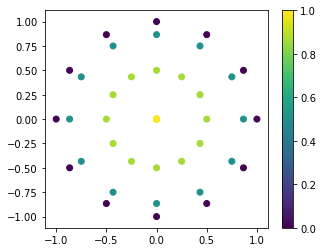

In [61]:
# shell ind will be the same at each radius even for different directions, so it could be worth calculating in advance and storing
v_angs = ma.generate_angles(mode='dist',alpha=90,tilt2='gamma',dist_n2=6)
norms = []
for a in v_angs:
    mrot = ma.rotation_matrix(a[0],a[1],a[2])
    n = mrot.dot([0,0,1])
    norms.append(n)
    
plt.figure(figsize=(5,4))
plt.scatter(np.take(norms,0,axis=1),np.take(norms,1,axis=1),c=np.take(norms,2,axis=1))
plt.colorbar()

In [135]:
def opt_factory(all_shell_inds):
    # by nesting in this way, all_shell_inds parameter can be returned and updated
    # along with a callable optimisation function - see 'python closure'
    def opt_fun2(x,crd,fs_volume,v,mode,thresh,gsp,centres,all_shell_inds):
        print(x)
        if x < 1:
            x = 1
        try:
            shell_ind = all_shell_inds[str(int(x))]
        except:
            shell_ind = shell_neighbours(gsp,centres,int(x))
            all_shell_inds[str(int(x))] = shell_ind
            
        dc_ratio,_ = completeness_ratio(crd,shell_ind,fs_volume,v=v,mode=mode,thresh=thresh,cone_angle=15)
        
        return abs(0.5-dc_ratio) + 1/(x-int(x))
    
    return opt_fun2, all_shell_inds

def dc_ratio_opt2(crd,fs_volume,v,mode,gsp,centres,all_shell_inds,thresh=None,x0=20,xatol=.5,fatol=.1):
    cons = ({'type':'eq','fun': lambda x : max([x[i]-int(x[i]) for i in range(len(x))])}) # integer
    res = scipy.optimize.minimize(opt_fun2,x0,args=(crd,fs_volume,v,mode,thresh,gsp,centres,all_shell_inds),method='Nelder-mead',
                                  options={'xatol':xatol,'fatol':fatol},constraints=cons,bounds=(1,100))
    return int(res.x[0])

In [136]:
all_shell_inds = {}
all_res = []
#gsp,crd,centres = prepare_radius_search(final_crop)

opt_fun2, all_shell_inds = opt_factory(all_shell_inds)

dc_ratio_opt2(crd,final_crop,[2,2,1],'thresh',gsp,centres,all_shell_inds,thresh=1,xatol=.1,fatol=0.02)

[ 20.]


C:\Users\grl31\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


[ 21.]
[ 19.]
[ 20.5]
[ 21.]
[ 20.25]
[ 20.75]
[ 21.]
[ 21.]
[ 20.625]
[ 20.875]
[ 21.]
[ 21.]
[ 20.8125]
[ 20.9375]
[ 21.]
[ 21.]
[ 20.90625]
[ 20.96875]
[ 21.]
[ 21.]
[ 20.953125]


20

In [125]:
opt_fun2, all_shell_inds = opt_factory(all_shell_inds)
res = scipy.optimize.minimize(opt_fun2,8,args=(crd,final_crop,[2,2,1],'thresh',1,gsp,centres,all_shell_inds),method='Nelder-mead')

[ 8.]
[ 8.4]
[ 7.6]
[ 8.2]
[ 8.2]
[ 7.8]
[ 8.1]
[ 8.1]
[ 7.9]
[ 8.05]
[ 8.05]
[ 7.95]
[ 8.025]
[ 8.025]
[ 7.975]
[ 8.0125]
[ 8.0125]
[ 7.9875]
[ 8.00625]
[ 8.00625]
[ 7.99375]
[ 8.003125]
[ 8.003125]
[ 7.996875]
[ 8.0015625]
[ 8.0015625]
[ 7.9984375]
[ 8.00078125]
[ 8.00078125]
[ 7.99921875]
[ 8.00039062]
[ 8.00039062]
[ 7.99960938]
[ 8.00019531]
[ 8.00019531]
[ 7.99980469]
[ 8.00009766]
[ 8.00009766]


In [139]:
#res
opt_fun2(19,crd,final_crop,[2,2,1],'thresh',1,gsp,centres,{})

19


ZeroDivisionError: division by zero

In [108]:
dc_ratio,_ = completeness_ratio(crd,shell_ind,final_crop,v=[2,2,1],mode='thresh',thresh=1,cone_angle=15)
dc_ratio

0.0

In [66]:
import scipy

In [75]:
all_shell_inds = {}
all_res = []
gsp,crd,centres = prepare_radius_search(final_crop)
for i,n in enumerate(norms):
    opt_fun2, all_shell_inds = opt_factory(all_shell_inds)
    res = dc_ratio_opt2(crd,final_crop,n.tolist(),'thresh',gsp,centres,all_shell_inds,thresh=1)
    print(i,res)
    all_res.append(res)

0 30
1 30
2 30
3 30
4 30
5 30
6 29
7 30
8 30
9 30
10 30
11 30
12 30
13 30
14 30
15 30
16 30
17 30
18 30
19 30
20 30
21 30
22 30
23 30
24 30
25 30
26 30
27 30
28 30
29 30
30 29
31 30
32 30
33 30
34 30
35 30
36 30
37 30
38 30
39 30
40 30
41 30


In [185]:
all_res_x = all_res

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


(-1.1176320772419339,
 1.1176320772419339,
 -1.1226239401696998,
 1.1226239401696998)

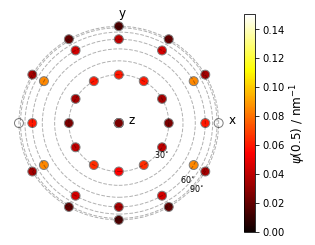

In [195]:
plt.figure(figsize=(5,4))
all_res = all_res_z
plt.scatter(np.take(norms,0,axis=1),np.take(norms,1,axis=1),c=np.array(all_res)*fpx,s=80,cmap='hot',edgecolors='gray',vmin=0,vmax=.15)
cbar = plt.colorbar()
cbar.set_label('$\psi (0.5)$ / nm$^{-1}$',fontsize=12)
#plt.axis('off')
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.title('')

thetas = np.linspace(30,90,7)*np.pi/180
z_markers = np.cos(thetas)
R = np.tan(thetas)*z_markers
#R = np.sin(thetas)/(1-np.cos(thetas))
#R = 1/(np.tan(thetas/2))
#z_markers=z
#R = np.divide(1, 1-z_markers, out=np.zeros_like(z_markers), where= (1-z_markers)!=0)

#R = (X**2 + Y**2)**.5
ax = plt.gca()
for i,r in enumerate(R):
    c = plt.Circle([0,0],radius=r,color='k',linestyle='--',alpha=.3,fill=False)
    ax.add_patch(c)
    
    xlab = r*np.cos(-np.pi/4)
    ylab = -xlab
    s = str(thetas[i]*180/np.pi)
    print(type(s))
    if i%3 == 0:
        plt.text(xlab,ylab,'%i$^{\circ}$' % np.round((thetas[i]*180/np.pi)),fontsize=8)

plt.text(0.1,0,'z',fontsize=12)
plt.text(1.1,0,'x',fontsize=12)
plt.text(0,1.1,'y',fontsize=12)
plt.axis('off')

In [262]:
#i = np.where(all_res_z>np.ones_like(all_res_z)*15)
i = np.where(all_res_z>np.ones_like(all_res_z)*7)[0]
for ind in i:
    all_res_z[ind] = 3
#all_res_z[np.where(all_res_z>np.ones_like(all_res_z)*15)[0]] = 4

In [260]:
i

array([15, 26, 27, 28, 30], dtype=int64)

([<matplotlib.axis.XTick at 0x25d0c8c3f98>,
 <a list of 6 Text xticklabel objects>)

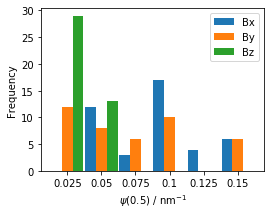

In [263]:
plt.figure(figsize=(4,3))
plt.hist([all_res_x,all_res_y,all_res_z],rwidth=.95,bins=[0,5,10,15,20,25,30])

plt.legend(['Bx','By','Bz'])
plt.xlabel('$\psi (0.5)$ / nm$^{-1}$')
plt.ylabel('Frequency')
plt.xticks(np.array([5,10,15,20,25,30])-2.5,np.array([5,10,15,20,25,30])*fpx)

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


Text(0, 4.1, 'y')

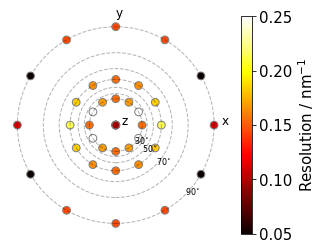

In [1030]:
x = np.take(norms,0,axis=1)
y = np.take(norms,1,axis=1)
z = np.take(norms,2,axis=1)
X = np.divide(x, 1-z, out=np.zeros_like(x), where= (1-z)!=0)
Y = np.divide(y, 1-z, out=np.zeros_like(x), where= (1-z)!=0)

plt.axes().set_aspect('equal')

thetas = np.linspace(30,90,7)*np.pi/180
#z_markers = np.cos(thetas)
#R = np.sin(thetas)/(1-np.cos(thetas))
R = 1/(np.tan(thetas/2))
#z_markers=z
#R = np.divide(1, 1-z_markers, out=np.zeros_like(z_markers), where= (1-z_markers)!=0)

#R = (X**2 + Y**2)**.5
ax = plt.gca()
for i,r in enumerate(R):
    c = plt.Circle([0,0],radius=r,color='k',linestyle='--',alpha=.3,fill=False)
    ax.add_patch(c)
    
    xlab = r*np.cos(-np.pi/4)
    ylab = -xlab
    s = str(thetas[i]*180/np.pi)
    print(type(s))
    if i%2 == 0:
        plt.text(xlab,ylab,'%i$^{\circ}$' % (120 - thetas[i]*180/np.pi),fontsize=8)

plt.scatter(X,Y,s=60,c=np.array(all_res)*fpx,cmap='hot',edgecolors='gray')
plt.axis('off')
cbar = plt.colorbar()
cbar.set_label('Resolution / nm$^{-1}$')
plt.text(0.2,0,'z',fontsize=12)
plt.text(4,0,'x',fontsize=12)
plt.text(0,4.1,'y',fontsize=12)


Text(0, 0.5, 'Resolution / nm$^{-1}$')

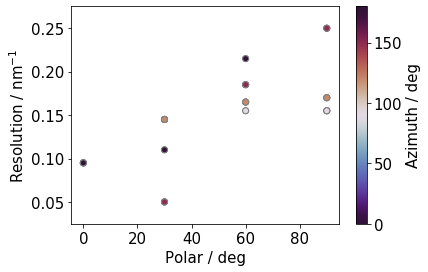

In [1027]:
sph_coor = angles_to_sph_coor(v_angs)
polar = np.take(sph_coor,0,axis=1)
merid = np.take(sph_coor,1,axis=1)
plt.scatter(polar,np.array(all_res)*fpx,c=merid,cmap='twilight_shifted',vmin=0,vmax=180,edgecolors='gray')
cbar = plt.colorbar()
cbar.set_label('Azimuth / deg')
#plt.plot(all_res,'.')
plt.xlabel('Polar / deg')
plt.ylabel('Resolution / nm$^{-1}$')

In [1044]:
shell_ind = shell_neighbours(gsp,centres,40)
_,inside = completeness_ratio(crd,shell_ind,fs_volume,v=[1,0.5,0],mode='thresh',thresh=0)
plot3D(final,inside=inside)

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed t

In [890]:
def angles_to_sph_coor(angles):
    """ Input sequence of angles
    return theta/phi pairs of spherical coordinates """
    # Calculate normals
    norms = []
    for i,a in enumerate(angles):
        mrot = ma.rotation_matrix(a[0],a[1],a[2])
        n = np.dot(mrot,[0,0,1])
        norms.append(n)

    # convert normals to spherical coordinates
    r=1
    sph_coor = []
    for i,n in enumerate(norms):
        theta = np.arccos(n[2])
        phi = np.arctan2(n[1],n[0]) # using atan2 keeps signs correct
        theta,phi = theta *180/np.pi, phi *180/np.pi

        sph_coor.append([theta,phi])
        
    return sph_coor

In [881]:


%env PROJ_LIB = /home/grl31/anaconda3/envs/astraenv/share/proj
from mpl_toolkits.basemap import Basemap

def plot_stereoproj(sph_coor,col='red',ax=None,title='Stereographic projection'):
    
    if ax == None:
        plt.figure(figsize=(9,9))
        ax = plt.gca()
    

    # setup south polar stereographic basemap.
    # The longitude lon_0 is at 6-o'clock, and the
    # latitude circle boundinglat is tangent to the edge
    # of the map at lon_0. Default value of lat_ts
    # (latitude of true scale) is pole.
    
    m = Basemap(projection='spstere',boundinglat=0,lon_0=0,resolution='l',ax=ax)
    # draw parallels and meridians.
    m.drawparallels(np.arange(-90.,1.,10.),linewidth=2,alpha=.5,color='gray') # parallel = latitude
    m.drawmeridians(np.arange(-180.,181.,30.),linewidth=2,alpha=.5,color='gray') # meridian = longitude
    m.drawmapboundary(fill_color='lightcyan')
    # draw tissot's indicatrix to show distortion.
    #ax = plt.gca()
    for c in sph_coor:
        theta,phi = c
        lon, lat = phi, theta-90
        poly = m.tissot(lon,lat,2,100,\
                        facecolor=col,zorder=10,alpha=0.5,ax=ax)

    ax.set_title(title,fontsize=20)

env: PROJ_LIB=/home/grl31/anaconda3/envs/astraenv/share/proj


ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

## Scalar

In [707]:
# Generate fourier volume
angles = ma.generate_angles(n_tilt=20)
final = fourier_slices3D(angles)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.36s/it]


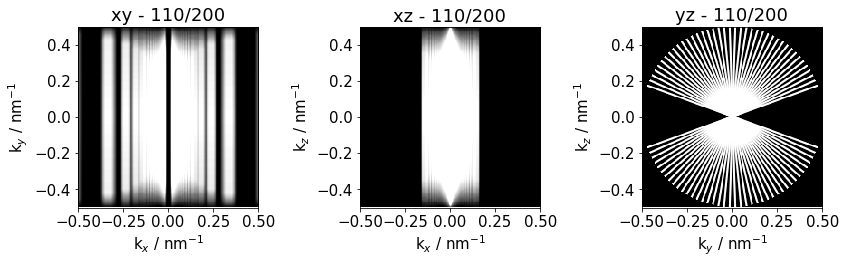

In [745]:
# View orthoslices
i_slice = 1
fig,axs = plt.subplots(ncols=3,figsize=(12,4))
plot3d_orthoslices(final,plane='xy',i_slice=i_slice,ax=axs[0])
plot3d_orthoslices(final,plane='xz',i_slice=i_slice,ax=axs[1])
plot3d_orthoslices(final,plane='yz',i_slice=i_slice,ax=axs[2])
plt.tight_layout()

In [253]:
# View in 3D
plot3D(final,)

In [708]:
# Get grid, coordinates, and array centre
gsp,crd,centres = prepare_radius_search(final)

In [255]:
# Find points at given radius
shell_ind = shell_neighbours(gsp,centres,10)

In [716]:

all_rat = []
for t in thresh:
    rats = calculate_completeness_series(gsp,centres,crd,final,thresh=t,mode='val',extent=30,v=[0,0,1])
    all_rat.append(rats)


TypeError: 'NoneType' object is not iterable

In [89]:
import time
ti = time.time()
rat_val = calculate_completeness_series(gsp,centres,crd,final_crop,thresh=t,mode='val',v=[2,2,1],cone_angle=15)
tf = time.time()
print(tf-ti)

100%|█████████████████████████████████████████████████████████████████████████████████| 38/38 [00:22<00:00,  1.71it/s]
22.274065017700195


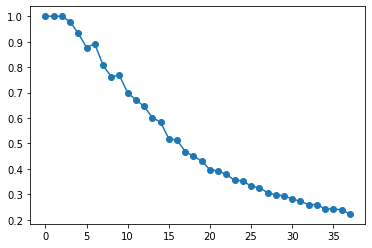

In [90]:
plt.plot(rat_val,'-o')

Text(0.5, 1.0, 'Scalar, non-directional')

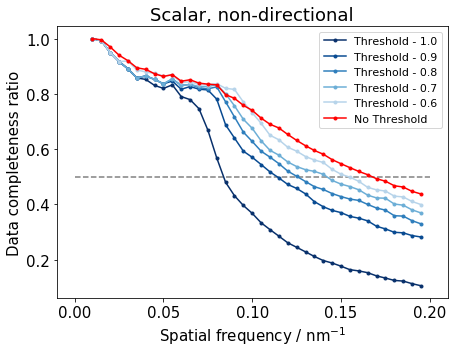

In [330]:
cmap = matplotlib
cmap = matplotlib.cm.get_cmap('Blues_r')
thresh=[1,.9,.8,.7,.6]
plt.figure(figsize=(7,5))
plt.plot([0,0.2],[.5,.5],'k--',alpha=.5)
for i,t in enumerate(all_rat):
    col = cmap(i/5-.1)
    plt.plot(np.arange(2,40)*fpx,t,'.-',color=col,label='Threshold - %.1f'%thresh[i])
    plt.title('Threshold')
   

plt.plot(np.arange(2,40)*fpx,rat_val,'r.-',label='No Threshold')

plt.legend(fontsize=11)
plt.ylabel('Data completeness ratio')
plt.xlabel('Spatial frequency / nm$^{-1}$')
plt.title('Scalar, non-directional')

In [230]:
d = 100
n=100
N = 200
rpx = d/n
fpx = 1/rpx / N
fpx*20

0.1

## Vector

In [18]:
angles = ma.generate_angles(n_tilt=20)
finalx,finaly,finalz = fourier_slices3D(angles,vector_components=True)

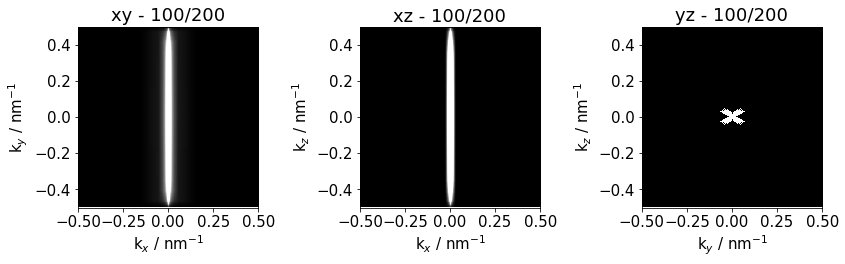

In [598]:
# View orthoslices
i_slice = None
f = finalz
fig,axs = plt.subplots(ncols=3,figsize=(12,4))
plot3d_orthoslices(f,plane='xy',i_slice=i_slice,ax=axs[0])
plot3d_orthoslices(f,plane='xz',i_slice=i_slice,ax=axs[1])
plot3d_orthoslices(f,plane='yz',i_slice=i_slice,ax=axs[2],vmin=.9999999999999)
plt.tight_layout()

In [531]:
plot3D(finalz)

In [78]:
# Get grid, coordinates, and array centre
gsp,crd,centres = prepare_radius_search(final_crop)

In [79]:
all_rat = []
thresh=[1,.9,.8,.7,.6]
for t in thresh:
    rats = calculate_completeness_series(gsp,centres,crd,final_crop,extent=40,thresh=t,mode='thresh',v=[2,2,1])
    all_rat.append(rats)

100%|█████████████████████████████████████████████████████████████████████████████████| 38/38 [00:22<00:00,  1.72it/s]


In [80]:
rat_val = calculate_completeness_series(gsp,centres,crd,final_crop,extent=40,thresh=t,mode='val',v=[2,2,1])

100%|█████████████████████████████████████████████████████████████████████████████████| 38/38 [00:22<00:00,  1.67it/s]


In [59]:
fpx=1/200
0.1 - 1.5*fpx

0.0925

Text(0.5, 1.0, 'x-component, [2,2,1] direction')

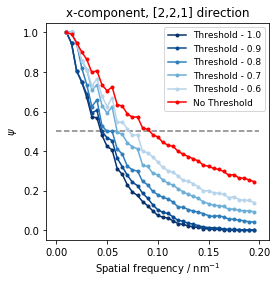

In [81]:
cmap = matplotlib
cmap = matplotlib.cm.get_cmap('Blues_r')
thresh=[1,.9,.8,.7,.6]
plt.figure(figsize=(4,4))
plt.plot([0,0.2],[.5,.5],'k--',alpha=.5)
for i,t in enumerate(all_rat):
    col = cmap(i/5-.1)
    plt.plot(np.arange(2,40)*fpx,t,'.-',color=col,label='Threshold - %.1f'%thresh[i])
    plt.title('Threshold')
   

plt.plot(np.arange(2,40)*fpx,rat_val,'r.-',label='No Threshold')

plt.legend(fontsize=9)
plt.ylabel('$\psi$')
plt.xlabel('Spatial frequency / nm$^{-1}$')
plt.title('x-component, [2,2,1] direction')

## Test specific radius

In [488]:
# Get grid, coordinates, and array centre
gsp,crd,centres = prepare_radius_search(finalz)

In [489]:
rats = calculate_completeness_series(gsp,centres,crd,final,extent=30,v=[0,0.6,0.8])

 82%|███████████████████████████████████████████████████████████████████▎              | 23/28 [00:07<00:01,  3.14it/s]


KeyboardInterrupt: 

In [ ]:
plot3D

In [449]:
all_rat = []
for t in thresh:
    rats = calculate_completeness_series(gsp,centres,crd,final,extent=30,thresh=t,mode='thresh',v=[1,0,0])
    all_rat.append(rats)

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:10<00:00,  2.73it/s]


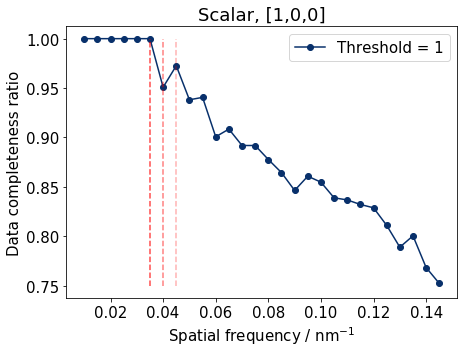

In [478]:
cmap = matplotlib
cmap = matplotlib.cm.get_cmap('Blues_r')
thresh=[1,.9,.8,.7,.6]
plt.figure(figsize=(7,5))
#plt.plot([0,0.2],[.5,.5],'k--',alpha=.5)
# for i,t in enumerate(all_rat):
#     col = cmap(i/5-.1)
#     plt.plot(np.arange(2,30)*fpx,t,'.-',color=col,label='Threshold - %.1f'%thresh[i])
#     plt.title('Threshold')
   
plt.plot(np.arange(2,30)*fpx,all_rat[0],'-o',color=cmap(0))

#plt.legend(fontsize=11)
plt.ylabel('Data completeness ratio')
plt.xlabel('Spatial frequency / nm$^{-1}$')
plt.title('Scalar, [1,0,0]')
plt.legend(['Threshold = 1'])

plt.plot([7*fpx,7*fpx],[.75,1],'r--',alpha=.7)
plt.plot([8*fpx,8*fpx],[.75,1],'r--',alpha=.5)
plt.plot([9*fpx,9*fpx],[.75,1],'r--',alpha=.3)

(-0.1, 0.1)

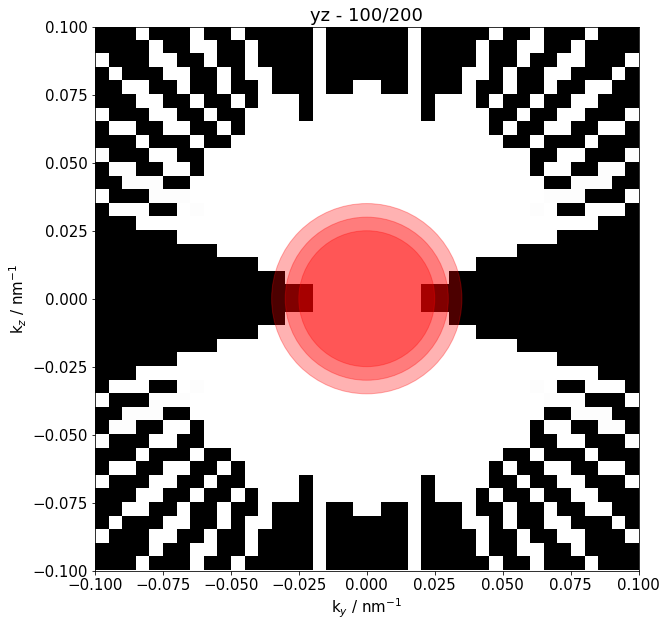

In [472]:
i_slice = 100
fig,ax = plt.subplots(figsize=(10,10))
plot3d_orthoslices(final,plane='yz',i_slice=i_slice,ax=ax,vmin=.9999999)

c = plt.Circle([0,0],radius=5*fpx,color='r',alpha=.3)
ax = plt.gca()
ax.add_patch(c)

c = plt.Circle([0,0],radius=6*fpx,color='r',alpha=.3)
ax = plt.gca()
ax.add_patch(c)

c = plt.Circle([0,0],radius=7*fpx,color='r',alpha=.3)
ax = plt.gca()
ax.add_patch(c)


l=.1
plt.xlim([-l,l])
plt.ylim([-l,l])

In [590]:
def completeness_ratio(crd,shell_ind,fs_volume,v=None,cone_angle=30,thresh=1,mode='val'):
    """ Given full coordinate space, and indices of points at given radius,
    calculates the ratio of points with/without data
    Currently can try with mode = 'val' or 'thresh' """
    filled_inds = []
    angs = []
    full,tot = 0,0
    # for each point at radius, evaluate value
    cent = int(np.round(np.shape(crd)[0]**(1/3))/2)
    for i in range(len(shell_ind[0])):
        # get vector from origin to point
        ind = np.array(crd[shell_ind[0][i]])-cent
        
        # directional
        if v != None:
            # Calculate angle between v and ind
            angle = np.arccos(np.dot(ind,v)/(np.linalg.norm(ind)*np.linalg.norm(v)))*180/np.pi
            angs.append(angle)

            # If angle is in right direction, evaluate value of point
            if angle < cone_angle or angle > 180-cone_angle:
                val = fs_volume[ind[0]+cent,ind[1]+cent,ind[2]+cent]
                
                if mode == 'thresh':
                    if val >= thresh:
                        full += 1
                        filled_inds.append(ind)
                if mode == 'val':
                    full += val
                tot += 1
                
        # non-directional        
        if v == None:
            val = fs_volume[ind[0]+cent,ind[1]+cent,ind[2]+cent]
            if mode == 'thresh':
                
                if val >= thresh:
                    #print(val,thresh,ind)
                    full += 1
                    filled_inds.append(ind)
            if mode == 'val':
                full += val
            tot += 1
        
    return full/tot, filled_inds

In [584]:
finalz[100-7,100-7,100+4]

1.0

In [20]:
# Get grid, coordinates, and array centre
gsp,crd,centres = prepare_radius_search(final_crop)

In [38]:
# Find points at given radius
shell_ind = shell_neighbours(gsp,centres,40)

_,filled_inds = completeness_ratio(crd,shell_ind,final_crop,thresh=0,mode='thresh',v=[2,2,1])
#_,all_inds = completeness_ratio(crd,shell_ind,finalz,v=[0,0.6,0.8],thresh=-1,mode='thresh')

In [39]:
plot3D(final_crop,inside=filled_inds,s=3,black=False)

In [42]:
40*1/200

0.2

In [1064]:
fpx*200
fmax = .5 # nm-1 = 1/2 n/d = 100/100 / 2
nmax = fmax/fpx
nmax

100.0

In [205]:
final_crop = copy.deepcopy(finalz)
a,b,c = np.shape(final_crop)
for i in range(a):
    for j in range(b):
        for k in range(c):
            cx = 100-i
            cy = 100-j
            cz = 100-k
            r = (cx**2 + cy**2 + cz**2)**.5
            if r > 100:
                final_crop[i,j,k] = 0
        

In [206]:
res = find_crit_rad(crd,final_crop,None)
res*fpx

0.05

In [526]:
np.min(finalz[filled_inds])

0.0

In [402]:
empty = np.zeros((200,200,200))
empty[np.array(all_inds)+100]=1

In [399]:
filled_inds[1]

array([-1, -4,  8], dtype=int64)

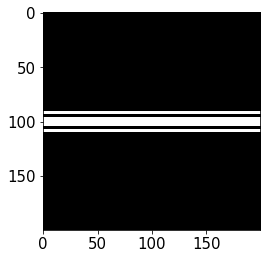

In [403]:
avg = np.mean(empty,axis=2)
plt.imshow(avg,cmap='gray')

In [2]:

def shell_neighbours(gsp,centres,lower_radii,rad_range=1):
    """ Takes grid and lower radius value and returns 
    indices of points in the grid that are at that radius """
    upper_radii = lower_radii+rad_range
    shell_dist, shell_ind = gsp.shell_neighbors(
        centres,
        distance_lower_bound=lower_radii,
        distance_upper_bound=upper_radii
    )
    
    return shell_ind

In [182]:


def shell_neighbours(gsp,centres,lower_radii,rad_range=1):
    """ Takes grid and lower radius value and returns 
    indices of points in the grid that are at that radius """
    upper_radii = lower_radii+rad_range
    shell_dist, shell_ind = gsp.shell_neighbors(
        centres,
        distance_lower_bound=lower_radii,
        distance_upper_bound=upper_radii
    )
    
    return shell_ind




def data_completeness_ratio(shell_ind,crd,thresh=1):
    full = 0
    empty = 0
    #final
    filled_inds = []
    for i in range(len(shell_ind[0])):
        ind = crd[shell_ind[0][i]]
        
        val = final[ind[0],ind[1],ind[2]]
        #print(val)
        if val > thresh:
            full += 1
            filled_inds.append(ind)
        else:
            empty += 1
    return full/(empty+full), filled_inds


def data_completeness_ratio_vec(shell_ind,crd,f,thresh=1):
    vals = 0
    tots = 0
    #final
    filled_inds = []
    for i in range(len(shell_ind[0])):
        ind = crd[shell_ind[0][i]]
        
        val = f[ind[0],ind[1],ind[2]]
        #print(val)
        vals += val
        tots +=1
    return vals/tots, filled_inds

# add directionality



In [ ]:
import scipy
import time

def opt_fun(x):
    shell_ind = shell_neighbours(gsp,centres,int(x))
    dc_ratio,_ = data_completeness_ratio(shell_ind,crd,thresh=1)
    return abs(0.5-dc_ratio)

def opt_fun_dir(x):
    shell_ind = shell_neighbours(gsp,centres,int(x))
    dc_ratio,_ = directional_completeness_ratio(crd,shell_ind,v=[1,-1,0])
    return abs(0.5-dc_ratio)

def opt_fun_vec(x):
    shell_ind = shell_neighbours(gsp,centres,int(x))
    dc_ratio,_ = data_completeness_ratio_vec(shell_ind,crd,fz)
    return abs(0.5-dc_ratio)


ti = time.time()
# cons = (
#         {'type':'eq','fun': lambda x : max([x[i]-int(x[i]) for i in range(len(x))])})
res = scipy.optimize.minimize(opt_fun_vec,30,method='Nelder-mead')
#res = scipy.optimize.differential_evolution(opt_fun, bounds=[(0,100)]) #global min 'guaranteed' but slower
tf = time.time()
print(tf-ti)

In [624]:
# speed test 
ts = []
for i in range(20):
    ti = time.time()
    P = ndimage.rotate(final,30,reshape=False,axes=(1,2),order=1)
    tf = time.time()

    t = tf-ti
    ts.append(t)
print('%.3f s +/- %.3f' % (np.mean(ts),np.std(ts)/10**.5))

1.067 s +/- 0.031


In [625]:
ts = []
for i in range(20):
    ti = time.time()
    P = ndimage.rotate(final,30,reshape=False,axes=(1,2),order=1,prefilter=False)
    tf = time.time()

    t = tf-ti
    ts.append(t)
print('%.3f s +/- %.3f' % (np.mean(ts),np.std(ts)/10**.5))

1.048 s +/- 0.009


In [669]:
for i in range(20):
    ti = time.time()
    P = fast_rotate(final,30)
    tf = time.time()

    t = tf-ti
    ts.append(t)
print('%.3f s +/- %.3f' % (np.mean(ts),np.std(ts)/10**.5))

0.771 s +/- 0.088


In [17]:
from PIL import Image

def fast_rotate(vol,angle,ind=0):
    P = np.zeros_like(vol)

    if ind == 0:
        for i in range(np.shape(vol)[0]):
            im = Image.fromarray(vol[i,:,:]*256).convert('L')
            rot = im.rotate(angle,Image.BILINEAR)
            P[i,:,:] = np.array(rot)/256

    if ind == 1:
        for i in range(np.shape(vol)[1]):
            im = Image.fromarray(vol[:,i,:]*256).convert('L')
            rot = im.rotate(angle,Image.BILINEAR)
            P[:,i,:] = np.array(rot)/256
            
    if ind == 2:
        for i in range(np.shape(vol)[2]):
            im = Image.fromarray(vol[:,:,i]*256).convert('L')
            rot = im.rotate(angle,Image.BILINEAR)
            P[:,:,i] = np.array(rot)/256
            
    return P

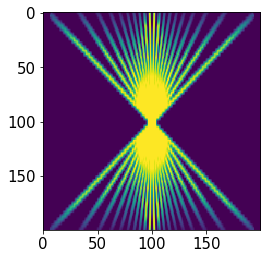

In [676]:
P = fast_rotate(final,70,ind=2)
plt.imshow(P[100,:,:])

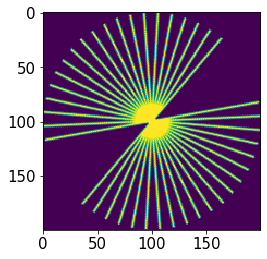

In [664]:
def rotate_bulk(P,ax,ay,az):
    """ 
    Rotate magnetisation locations from rotation angles ax,ay,az 
    about the x,y,z axes (given in degrees) 
    
    NOTE: This implementation of scipy rotations is EXTRINSIC
    Therefore, to make it compatible with our intrinsic vector
    rotation, we swap the order of rotations (i.e. x then y then z)
    """
    # Due to indexing, ay needs reversing for desired behaviour
    ay = -ay
    
    P = ndimage.rotate(P,ax,reshape=False,axes=(1,2),order=1)
    P = ndimage.rotate(P,ay,reshape=False,axes=(2,0),order=1)
    P = ndimage.rotate(P,az,reshape=False,axes=(0,1),order=1)

    return P

In [15]:
def fast_rotate_bulk(P,ax,ay,az):
    """ 
    Rotate magnetisation locations from rotation angles ax,ay,az 
    about the x,y,z axes (given in degrees) 
    
    NOTE: This implementation of scipy rotations is EXTRINSIC
    Therefore, to make it compatible with our intrinsic vector
    rotation, we swap the order of rotations (i.e. x then y then z)
    """
    # Due to indexing, ay needs reversing for desired behaviour
    ay = -ay
    
    P = fast_rotate(P,ax,ind=0)
    P = fast_rotate(P,ay,ind=1)
    P = fast_rotate(P,az,ind=2)
    
#     P = ndimage.rotate(P,ax,reshape=False,axes=(1,2),order=1)
#     P = ndimage.rotate(P,ay,reshape=False,axes=(2,0),order=1)
#     P = ndimage.rotate(P,az,reshape=False,axes=(0,1),order=1)

    return P

In [684]:
x,y,z,P = ma.generate_layered_rod()

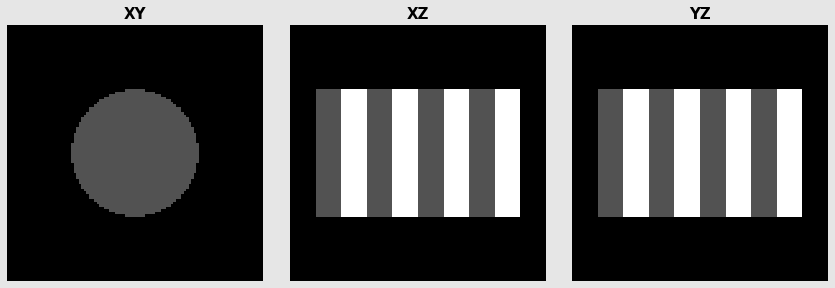

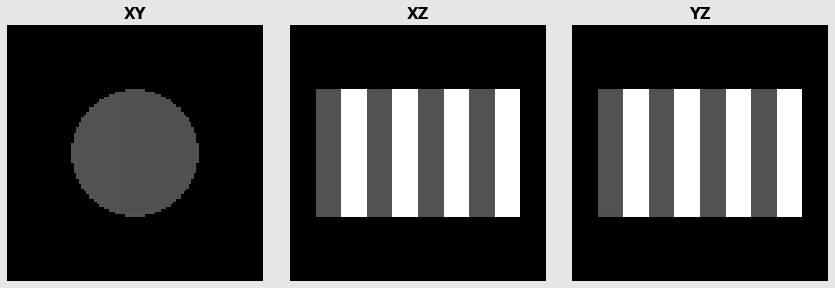

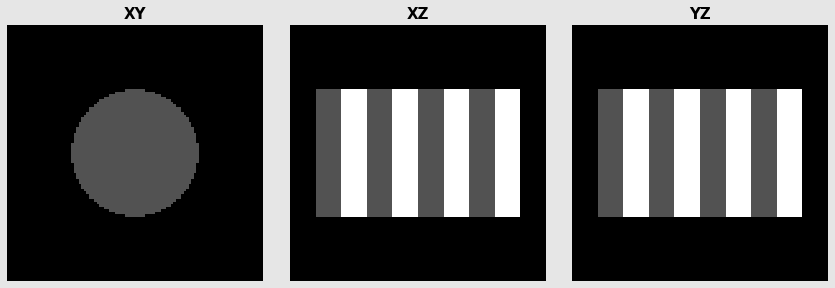

In [705]:
ma.plot_orthoslices(P)
ax,ay,az=360,360,360
Prot1 = ma.rotate_bulk(P,ax,ay,az)
ma.plot_orthoslices(Prot1)
Prot2 = fast_rotate_bulk(P,ax,ay,az)
ma.plot_orthoslices(Prot2)

In [696]:
comp = Prot1 == Prot2

In [697]:
comp.all()

False

In [700]:
np.sum(comp)

0.87724000000000002

In [699]:
np.shape(comp)

(100, 100, 100)

In [1045]:
angles = ma.generate_angles(n_tilt=40)

#final = fourier_slices3D(angles) # scalar

In [1047]:
axs = angles = np.linspace(0,90,num=5)
angles = []
for a in axs:
    angles.append([a,0,0])
    
angles

[[0.0, 0, 0], [22.5, 0, 0], [45.0, 0, 0], [67.5, 0, 0], [90.0, 0, 0]]

In [1052]:
final = fourier_slices3D(angles[:3])

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


(-0.5, 0.5, -0.5, 0.5)

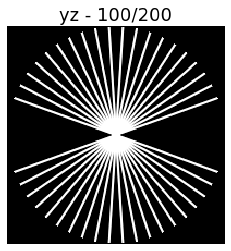

In [1058]:
plot3d_orthoslices(finalx,plane='yz')
plt.axis('off')

In [1055]:
angles[:3]

[[0.0, 0, 0], [22.5, 0, 0], [45.0, 0, 0]]